# DQN 구현
https://youtu.be/XiigTGKZfks
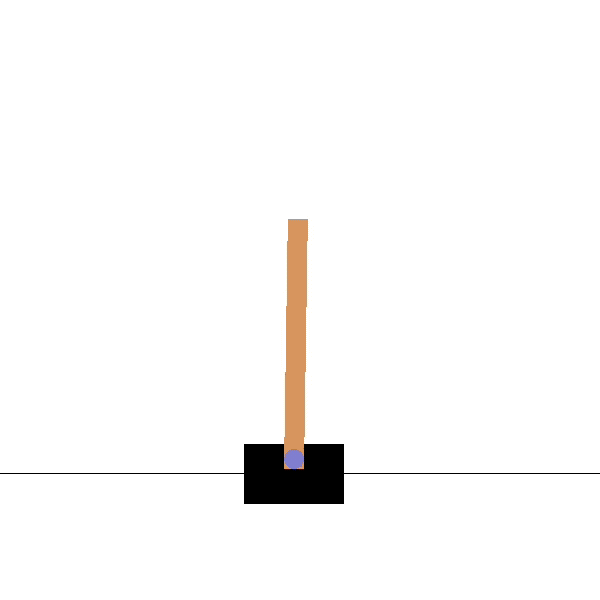  
파이토치를 활용  
'바닥부터 배우는 강화 학습' 도서 내용을 기반으로 작성하였음.

In [1]:
import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Hyperparameters
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32

In [5]:
# 리플레이 버퍼 클래스 
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

In [15]:
# Q밸류 네트워크 클래스
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()

In [24]:
# 학습 함수
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()  # loss에 대한 그라디언트 계산이 일어남
        optimizer.step()

In [25]:
# 메인 함수
def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%" \
                  .format(n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0
    env.close()

In [26]:
if __name__ == '__main__':
    main()

n_episode :20, score : 10.3, n_buffer : 206, eps : 7.9%
n_episode :40, score : 10.1, n_buffer : 408, eps : 7.8%
n_episode :60, score : 9.9, n_buffer : 606, eps : 7.7%
n_episode :80, score : 9.7, n_buffer : 800, eps : 7.6%
n_episode :100, score : 9.4, n_buffer : 989, eps : 7.5%
n_episode :120, score : 9.6, n_buffer : 1181, eps : 7.4%
n_episode :140, score : 9.9, n_buffer : 1379, eps : 7.3%
n_episode :160, score : 10.2, n_buffer : 1582, eps : 7.2%
n_episode :180, score : 9.5, n_buffer : 1772, eps : 7.1%
n_episode :200, score : 9.5, n_buffer : 1962, eps : 7.0%
n_episode :220, score : 15.8, n_buffer : 2278, eps : 6.9%
n_episode :240, score : 23.8, n_buffer : 2753, eps : 6.8%
n_episode :260, score : 16.6, n_buffer : 3085, eps : 6.7%
n_episode :280, score : 17.3, n_buffer : 3431, eps : 6.6%
n_episode :300, score : 21.7, n_buffer : 3865, eps : 6.5%
n_episode :320, score : 36.4, n_buffer : 4592, eps : 6.4%
n_episode :340, score : 65.8, n_buffer : 5907, eps : 6.3%
n_episode :360, score : 82.8, 